In [1]:
import numpy as np
import scipy.optimize as so
import matplotlib.pyplot as plt
from cryoBIFE import neglogpost_cryobife, normal_prior
from cryoBIFE.Generate_Gaussian_Images_Toymodel import sample_grid_data, get_num_images
from tqdm import tqdm
import scipy.linalg as spl

In [2]:
def get_optimal_string_fe(posterior_matrix, log_prior_fxn, kappa=1.0):
    number_of_nodes = posterior_matrix.shape[1]
    G_init = 0.5 * np.random.randn(number_of_nodes)# Initial free energy differences
    G_op = so.minimize(neglogpost_cryobife, G_init, method='L-BFGS-B', args=(kappa, posterior_matrix))
    # Second optimization using Conjugate Gradients
    G_op = so.minimize(neglogpost_cryobife, G_op.x, method='CG', args=(kappa, posterior_matrix, log_prior_fxn))
    print(G_op.message)
    print('Jacobian', G_op.jac)
    print("X value:", G_op.x)
#     assert(G_op.success)

    optimal_string_fe = G_op.x
    optimal_logpost = -1 * G_op.fun
    return optimal_string_fe, optimal_logpost



def histogram_raw_data(coords):
    y = coords[:, 0]
    x = coords[:, 1]
    print(np.min(x), np.max(x))
    print(np.min(y), np.max(y))

    hist, xedges, yedges = np.histogram2d(x, y, bins=100, range=((-5, 25), (-5, 25)))

    plt.imshow(hist.T, interpolation='nearest', origin='lower',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

    plt.show()
    
def gradient_f(x, f):
    assert (x.shape[0] >= x.shape[1]), "the vector should be a column vector"
    x = x.astype(float)
    N = x.shape[0]
    gradient = []
    for i in range(N):
        eps = abs(x[i]) *  np.finfo(np.float32).eps 
        xx0 = 1. * x[i]
        f0 = f(x)
        x[i] = x[i] + eps
        f1 = f(x)
        gradient.append(np.asscalar(np.array([f1 - f0]))/eps)
        x[i] = xx0
    return np.array(gradient).reshape(x.shape)

#Hessian Matrix
def hessian(x, the_func):
    print(x.shape)
    N = x.shape[0]
    hessian = np.zeros((N,N)) 
    gd_0 = gradient_f( x, the_func)
    eps = np.linalg.norm(gd_0) * np.finfo(np.float32).eps 
    for i in range(N):
        xx0 = 1.*x[i]
        x[i] = xx0 + eps
        gd_1 =  gradient_f(x, the_func)
        hessian[:,i] = ((gd_1 - gd_0)/eps).reshape(x.shape[0])
        x[i] =xx0
    return hessian


In [3]:
kappa = 1.0
dT = 1.
inv_T = 3.

N_total = 10000

def flat_prior(x):
    return 0

grid_info, black_info, orange_info = sample_grid_data(inverse_T=inv_T, N_total = N_total, sigma=1.0)
coords, Grid, Num_images = grid_info
#     print(len(coords))
black, Post_Matrix_black = black_info
black_fe, black_logpost = get_optimal_string_fe(Post_Matrix_black, normal_prior, kappa=kappa)

def opt_fxn(x):
    return neglogpost_cryobife(x.ravel(), kappa, Post_Matrix_black, normal_prior)

#     print(black_logpost, opt_fxn(black_fe.reshape(-1, 1)))

grad = gradient_f(black_fe.reshape(-1, 1), opt_fxn)
bhess = hessian(black_fe.reshape(-1, 1), opt_fxn)

Desired error not necessarily achieved due to precision loss.
Jacobian [-0.00048828  0.00048828  0.00048828  0.          0.00048828  0.
  0.          0.          0.          0.          0.          0.00048828
 -0.00048828  0.00048828]
X value: [-2.16230926 -0.34070096 -0.88802769  0.29446779  0.29994317  0.57185983
  1.78326991 -1.24085647  1.57396976  0.04000472  0.37984695 -0.01057623
 -0.23441216 -1.82359884]
(14, 1)


/tmp/ipykernel_91714/3831066385.py:42: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  gradient.append(np.asscalar(np.array([f1 - f0]))/eps)


/home/erik/miniconda3/envs/cryoem/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Index')

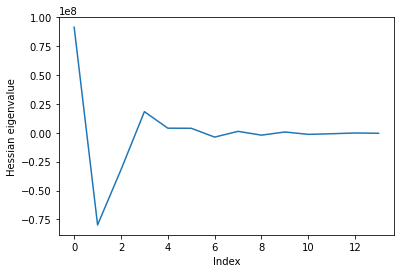

In [4]:
evals, evecs = spl.eig(bhess + bhess.T)
plt.plot(evals)
plt.ylabel('Hessian eigenvalue')
plt.xlabel("Index")


/tmp/ipykernel_91714/2515786075.py:3: RuntimeWarning: divide by zero encountered in log
  true_fe = -np.log(num_images)


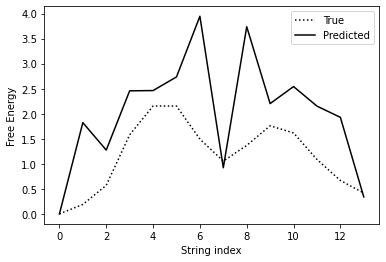

In [5]:
grid, num_images  = get_num_images(N_total, inv_T)

true_fe = -np.log(num_images)
true_fe -= np.min(true_fe)


bfi = black_fe - np.min(black_fe)
true_black_fe = true_fe[black[:, 0].astype('int'), black[:, 1].astype('int')]

fig, ax = plt.subplots(1)
ax.plot(true_black_fe, label='True', color='k', linestyle=':')
ax.plot(bfi, label='Predicted', color='k')
ax.set_xlabel('String index')
ax.set_ylabel('Free Energy')
ax.legend()